In [2]:
import pandas as pd
summ = pd.read_csv('summary_table_v1.4.csv')
raw = pd.read_csv('drugcomb_data_v1.4.csv')

block_to_study = raw[['block_id', 'study_name']].drop_duplicates()
summ = summ.merge(block_to_study, on='block_id')

mono = summ[summ['drug_col'].isna()]
comb = summ[~summ['drug_col'].isna()]

k562_mono = mono[mono['cell_line_name'] == 'K-562']
k562_combs = comb[comb['cell_line_name'] == 'K-562']

In [8]:
# Let's see how many drugs there are from CTRPv2 on the K-562 line
k562_mono[k562_mono['study_name'] == 'CTRPv2']['drug_row'].drop_duplicates()

1026543    (5E)-5-{[5-(1H-benzimidazol-2-ylthio)-2-furyl]...
1026544     9-[2-(1H-Benzoimidazol-2-yl)-ethyl]-9H-carbazole
1026545                                         MLS000106215
1026546                                  Bax Channel Blocker
1026547                                           32703-82-5
                                 ...                        
1027003                                          SKEPINONE-L
1027004                                        BRD-K34222889
1027005                             PF 4800567 Hydrochloride
1027006                                             AVICIN D
1027007                                 OSI-906 (LINSITINIB)
Name: drug_row, Length: 465, dtype: object

In [10]:
# Let's see how many cell lines were tested in the CTRPv2 study
mono[mono['study_name'] == 'CTRPv2']['cell_line_name'].drop_duplicates()

721559         CAS-1
721982          KPL1
722427          MKN1
722877       253J-BV
723255      BFTC-905
             ...    
1114485        SW982
1114947        SYO-1
1115419      Tm87-16
1115889      TTC-709
1116356    Yamato-SS
Name: cell_line_name, Length: 887, dtype: object

## How Should We Plot 3D Drug Score Consistency Visualization?

For making a 3D plot of drug score consistency across cell lines, we should probably only use the broad data and do two other things:

1. Take the drugs that we've seen on K-562 and plot the distribution of css scores for that drug across all the other cell lines
2. Take the 20 or 30 best cell lines for K-562 (maybe threshold them to some good css value would be better) and plot their 
   css score dstributions across all the other cell lines

In [41]:
# Setting up some dataframes...

broad_mono_data = mono[mono['study_name'] == 'CTRPv2']
k562_drugs = broad_mono_data[broad_mono_data['cell_line_name'] == 'K-562']

broad_mono_data['drug_idx'] = pd.Categorical(broad_mono_data['drug_row'])
broad_mono_data['drug_idx'] = broad_mono_data['drug_idx'].cat.codes

broad_mono_data['cell_line_idx'] = pd.Categorical(broad_mono_data['cell_line_name'])
broad_mono_data['cell_line_idx'] = broad_mono_data['cell_line_idx'].cat.codes

broad_mono_above_neg_30_css = broad_mono_data[broad_mono_data['css'] > -30]

/Users/jarridr/opt/anaconda3/envs/my-rdkit-env/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/jarridr/opt/anaconda3/envs/my-rdkit-env/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/jarridr/opt/anaconda3/envs/my-rdkit-env/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

In [115]:
from sklearn.neighbors import KernelDensity
from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numpy as np
import matplotlib.pyplot as plt

def get_idx_to_mean_css_df(mono_df, drug_df, css_thresh=None, top_k=None):
    copy_mono_df = mono_df
    copy_drug_df = drug_df
    
    # Check that we're not trying to threshold and take top k
    assert not (css_thresh is not None and top_k is not None)
    
    if top_k is not None:
        copy_drug_df = copy_drug_df.sort_values('css', ascending=False).iloc[:top_k] 
        
    if css_thresh is not None:
        copy_drug_df = copy_drug_df[copy_drug_df['css'] > css_thresh]
        
    drug_names = copy_drug_df['drug_row'].drop_duplicates()
    copy_mono_df = copy_mono_df[copy_mono_df['drug_row'].isin(drug_names)]
        
    return copy_mono_df.groupby(['drug_idx', 'cell_line_idx'])['css'].mean().reset_index()

def get_plotting_df(mono_df, drug_df, css_thresh=None, top_k=None):
    df = get_idx_to_mean_css_df(mono_df, drug_df, css_thresh, top_k)
    X_plot = np.linspace(-30, 100, 130 * 3)

    to_append = []
    result = pd.DataFrame(columns=['drug_idx', 'samp_css_score', 'samp_css_density'])
    for drug_idx, group in tqdm(df.groupby('drug_idx')):
        kde = KernelDensity().fit(group['css'].values.reshape(-1, 1))
        log_density = kde.score_samples(X_plot.reshape(-1, 1))
        
        tmp_df = pd.DataFrame()
        tmp_df['drug_idx'] = np.full(log_density.shape[0], drug_idx)
        tmp_df['samp_css_score'] = X_plot
        tmp_df['samp_css_density'] = np.minimum(.07, np.exp(log_density))
        
        to_append.append(tmp_df)
    
    result = result.append(to_append)
    return result

def plot(mono_df, drug_df, top_k=None, css_thresh=None, angle=None, fname='drug_css_across_lines'):
    plotting_df = get_plotting_df(mono_df, drug_df, css_thresh, top_k)
    
    fig = plt.figure(figsize=(14, 9))
    ax = fig.gca(projection='3d')
    ax.plot_trisurf(plotting_df['drug_idx'], plotting_df['samp_css_score'], 
                    plotting_df['samp_css_density'], cmap=plt.cm.viridis, linewidth=.02)
    
    ax.set_xlabel('Drug Index')
    ax.set_ylabel('CSS Score')
    ax.set_zlabel('Density of Score')
    
    if angle is not None:
        ax.view_init(30, angle)
        
    title_str = 'Distribution of CSS Score for %s Across All Lines in CTRPv2'
    inner_str = 'Drugs'
    if top_k is not None:
        inner_str = '%d Best Drugs on K-562' % top_k
        
    if css_thresh is not None:
        inner_str = 'Drugs With CSS Above %d on K-562' % css_thresh
        
    plt.title(title_str % inner_str)
    
    if fname != '':
        plt.savefig('%s.png' % fname)
    
    plt.show()
    
def plot_line_and_drug(mono_df, drug_df, top_k=None, css_thresh=None, elev=None, angle=None, fname='drug_css_across_lines'):
    plotting_df = get_idx_to_mean_css_df(mono_df, drug_df, css_thresh, top_k)
    
    fig = plt.figure(figsize=(14, 9))
    ax = fig.gca(projection='3d')
    ax.scatter(plotting_df['drug_idx'], plotting_df['cell_line_idx'], 
                    plotting_df['css'], cmap=cm.viridis, linewidth=.02)
    
    ax.set_xlabel('Drug Index')
    ax.set_ylabel('Cell Line Index')
    ax.set_zlabel('CSS')
    
    if elev is not None or angle is not None:
        ax.view_init(elev, angle)
        
    title_str = 'CSS Score %s Across All Lines in CTRPv2'
    inner_str = 'Drugs'
    if top_k is not None:
        inner_str = '%d Best Drugs on K-562' % top_k
        
    if css_thresh is not None:
        inner_str = 'Drugs With CSS Above %d on K-562' % css_thresh
        
    plt.title(title_str % inner_str)
    plt.savefig('non_density_%s.png' % fname)
    plt.show()
    

100%|██████████| 5/5 [00:00<00:00, 87.57it/s]


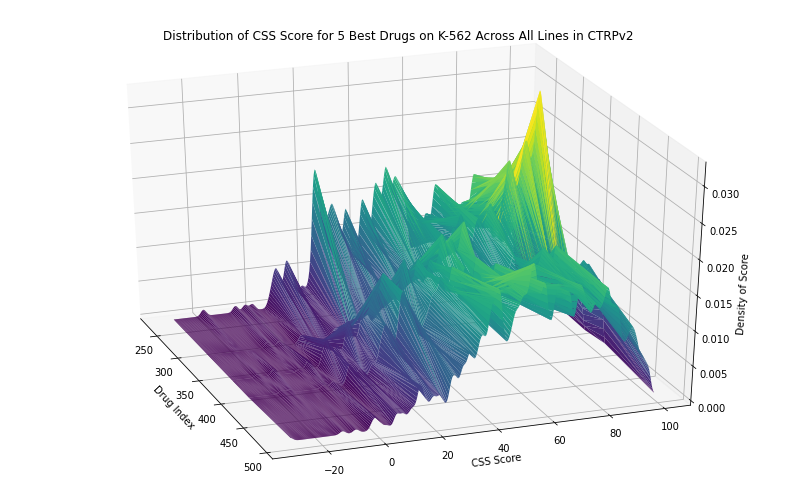

In [101]:
plot(broad_mono_data, k562_drugs, top_k=5, angle=340, fname='top_5_from_k562')

100%|██████████| 465/465 [00:03<00:00, 145.85it/s]


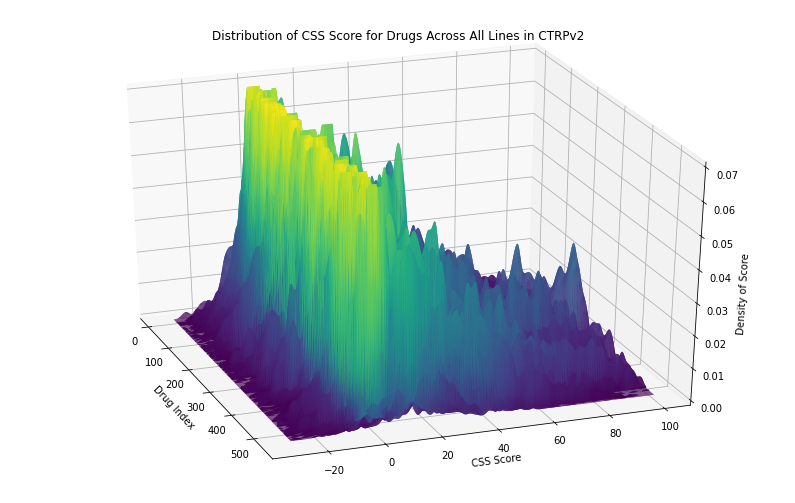

In [102]:
plot(broad_mono_data, k562_drugs, angle=340, fname='all_drugs_from_k562_across_lines')

100%|██████████| 9/9 [00:00<00:00, 103.89it/s]


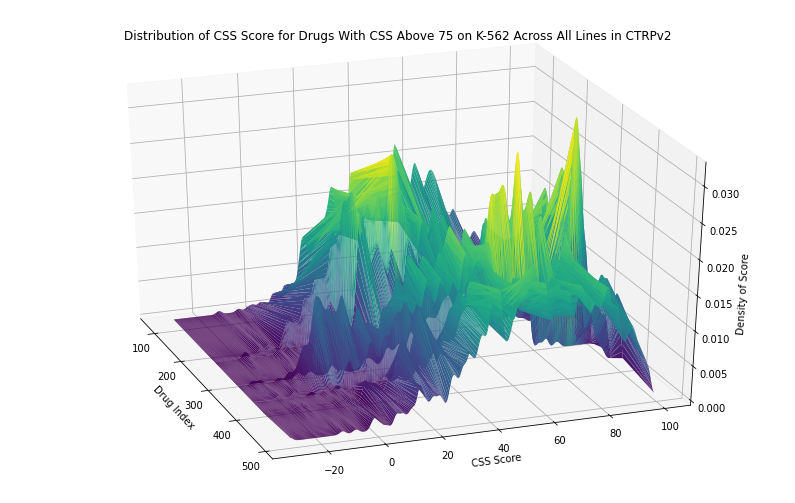

In [99]:
plot(broad_mono_data, k562_drugs, css_thresh=75, angle=340, fname='drugs_above_75_css_on_k562_across_lines')

100%|██████████| 7/7 [00:00<00:00, 96.27it/s]


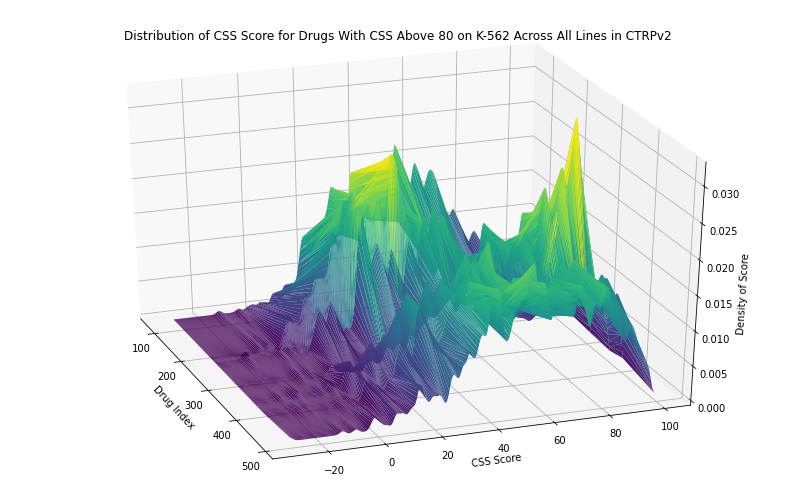

In [104]:
plot(broad_mono_data, k562_drugs, css_thresh=80, angle=340, fname='drugs_above_80_css_on_k562_across_lines')

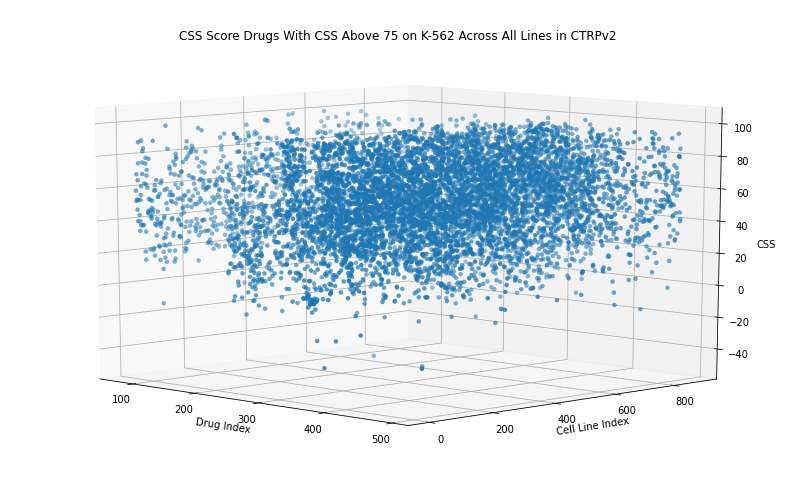

In [119]:
plot_line_and_drug(broad_mono_data, k562_drugs, css_thresh=75, elev=10, angle=315)

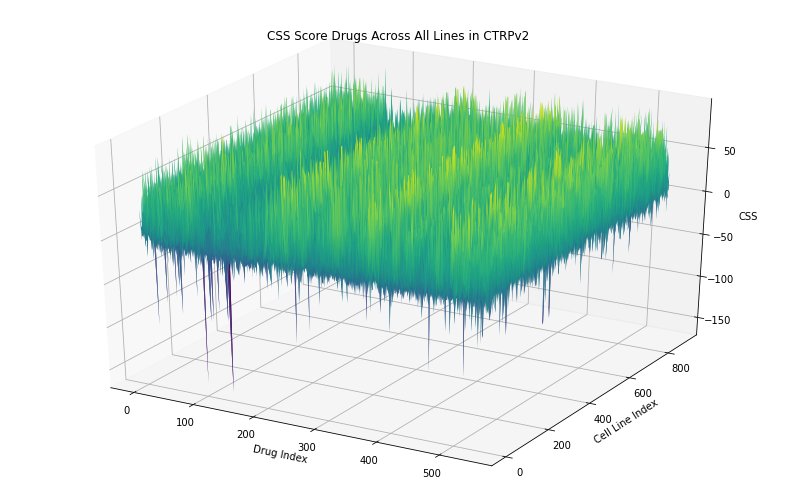

In [109]:
plot_line_and_drug(broad_mono_data, k562_drugs, fname='idk')

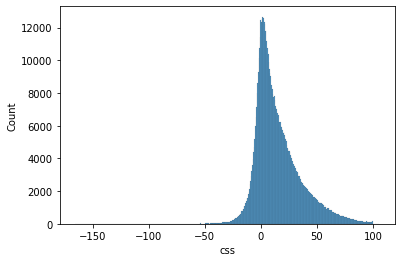

In [111]:
sns.histplot(mono['css'])